In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import logging
from tqdm import tqdm  # для progress bar
import time
import os

In [ ]:
# Настройка логирования
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('habr_parser.log'),  # Логи в файл
        logging.StreamHandler()  # Логи в консоль
    ]
)

# Создаем список для хранения данных
articles_data = []

# Настройки парсера
START_ID = 804000
END_ID = 806000  # Можно уменьшить для теста
REQUEST_TIMEOUT = 10  # Увеличим таймаут
DELAY_BETWEEN_REQUESTS = 1  # Задержка между запросами (в секундах)

# Создаем progress bar
progress_bar = tqdm(range(START_ID, END_ID + 1), desc="Парсинг статей", unit="статья")

for n in progress_bar:
    url = f"https://habr.com/ru/articles/{n}/"
    try:
        # Делаем запрос с таймаутом
        response = requests.get(url, timeout=REQUEST_TIMEOUT)
        response.raise_for_status()  # Проверяем на ошибки HTTP

        # Проверяем, что это статья (а не 404 или другая страница)
        if response.status_code == 404:
            progress_bar.set_postfix({"Статус": "404 - не найдено"})
            continue

        soup = BeautifulSoup(response.text, 'html.parser')

        # Проверяем, что статья имеет рейтинг (значит, это настоящая статья)
        rating = soup.find('span', {'data-test-id': 'votes-meter-value'})
        if not rating:
            progress_bar.set_postfix({"Статус": "Нет рейтинга - пропускаем"})
            continue

        # Получаем данные статьи
        title = soup.find('h1')
        if not title:
            progress_bar.set_postfix({"Статус": "Нет заголовка - пропускаем"})
            continue

        title_text = title.text.strip()
        article_body = soup.find('div', class_='tm-article-body')
        text = article_body.text.strip() if article_body else ""
        text = text.replace('\n', ' ').replace('\r', ' ')  # Нормализуем переносы строк
        tags = [tag.text.strip() for tag in soup.find_all('a', class_='tm-tags-list__link')]

        # Добавляем в список
        articles_data.append({
            'URL': url,
            'Рейтинг': rating.text.strip(),
            'Заголовок': title_text,
            'Текст статьи': text,
            'Длина текста': len(text),
            'Теги': ', '.join(tags)
        })

        progress_bar.set_postfix({
            "Статус": "Успешно",
            "Статей собрано": len(articles_data)
        })

    except requests.exceptions.RequestException as e:
        logging.error(f"Ошибка запроса {url}: {str(e)}")
        progress_bar.set_postfix({"Статус": f"Ошибка: {str(e)}"})
    except Exception as e:
        logging.error(f"Неожиданная ошибка при обработке {url}: {str(e)}", exc_info=True)
        progress_bar.set_postfix({"Статус": "Критическая ошибка"})

    # Делаем задержку между запросами, чтобы не нагружать сервер
    time.sleep(DELAY_BETWEEN_REQUESTS)

# Закрываем progress bar
progress_bar.close()

# Сохраняем данные, если что-то собрали
if articles_data:
    df = pd.DataFrame(articles_data)

    # Убедимся, что папка существует
    os.makedirs('results', exist_ok=True)

    # Сохраняем в CSV с датой в имени файла
    csv_filename = f"results/habr_articles_{pd.Timestamp.now().strftime('%Y%m%d_%H%M')}.csv"
    df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
    logging.info(f"\nУспешно собрано {len(df)} статей. Данные сохранены в '{csv_filename}'")

    # Дополнительно: сохраняем статистику по тегам
    tags_stats = df['Теги'].str.split(', ').explode().value_counts()
    tags_stats.to_csv(f"results/habr_tags_stats_{pd.Timestamp.now().strftime('%Y%m%d_%H%M')}.csv")

    # Выводим краткий отчет
    print("\nКраткая статистика:")
    print(f"Всего статей: {len(df)}")
    print(f"Средняя длина текста: {df['Длина текста'].mean():.0f} символов")
    print("\nТоп-10 тегов:")
    print(tags_stats.head(10))
else:
    logging.warning("Не удалось собрать ни одной статьи!")

Парсинг статей: 100%|██████████| 2001/2001 [58:14<00:00,  1.75s/статья, Статус=Ошибка: 404 Client Error: Not Found for url: https://habr.com/ru/articles/806000/]



Краткая статистика:
Всего статей: 735
Средняя длина текста: 10454 символов

Топ-10 тегов:
Теги
искусственный интеллект    31
ГОСТ                       19
Технический регламент      19
Терминология               19
Договор                    19
Контракт                   19
Техническое задание        19
Обязательство              19
Стандартизация             19
Информационная система     19
Name: count, dtype: int64


In [ ]:
import pandas as pd
df=pd.read_excel('all_habr_.xlsx')
df

,URL,Rating,Title,Article text,Text length,Hashtags
0,https://habr.com/ru/articles/804003/,4,В «Яндекс Картах» обновился режим парковки,«Яндекс Карты» обновили режим парковки: прилож...,1028,"яндекс, яндекс карты, парковки, москва"
1,https://habr.com/ru/articles/804005/,8,«Швабе» представил лазерный микроскоп для ранн...,Холдинг «Швабе» (входит в госкорпорацию «Росте...,1844,"микроскоп, швабе, ростех, онкология, изучение"
2,https://habr.com/ru/articles/804009/,9,Мини-ПК GEEKOM A7: что это за девайс и на что ...,Производители электроники каждую неделю выпуск...,4663,"гаджеты, настольные компьютеры, компьютерное ж..."
3,https://habr.com/ru/articles/804013/,8,Верховный суд обязал ВТБ выплатить НДС поставщ...,Верховный суд обязал банк ВТБ заплатить НДС в ...,1951,"втб, Энвижн Груп, ндс, microsoft"
4,https://habr.com/ru/articles/804017/,6,"Канадские школы подали в суд на Meta*, ByteDan...","Несколько канадских школ в Торонто, Оттаве и р...",1599,"meta, tiktok, facebook, snapchat, соцсети, канада"
...,...,...,...,...,...,...
2244,https://habr.com/ru/articles/800989/,7,Обзор планшета Blackview MEGA 1: больше экрана...,Планшет Blackview MEGA 1 это универсальное реш...,23898,"планшет, Blackview Mega 1"
2245,https://habr.com/ru/articles/800991/,0,Минцифры получит полномочия по проверке россий...,Правительство наделило Минцифры новыми полномо...,1019,"геинформационные технологии, минцифры, законод..."
2246,https://habr.com/ru/articles/800993/,52,"Игра, которую невозможно не полюбить","Здравствуйте, уважаемые хабровцы!Меня зовут Ер...",27610,"тогызкумалак, настольные игры, казахстан"
2247,https://habr.com/ru/articles/800997/,7,Применение стационарных умных приёмников звука...,"Фомичев В.А., полковник запаса, Крюков В.А.,...",11518,eda


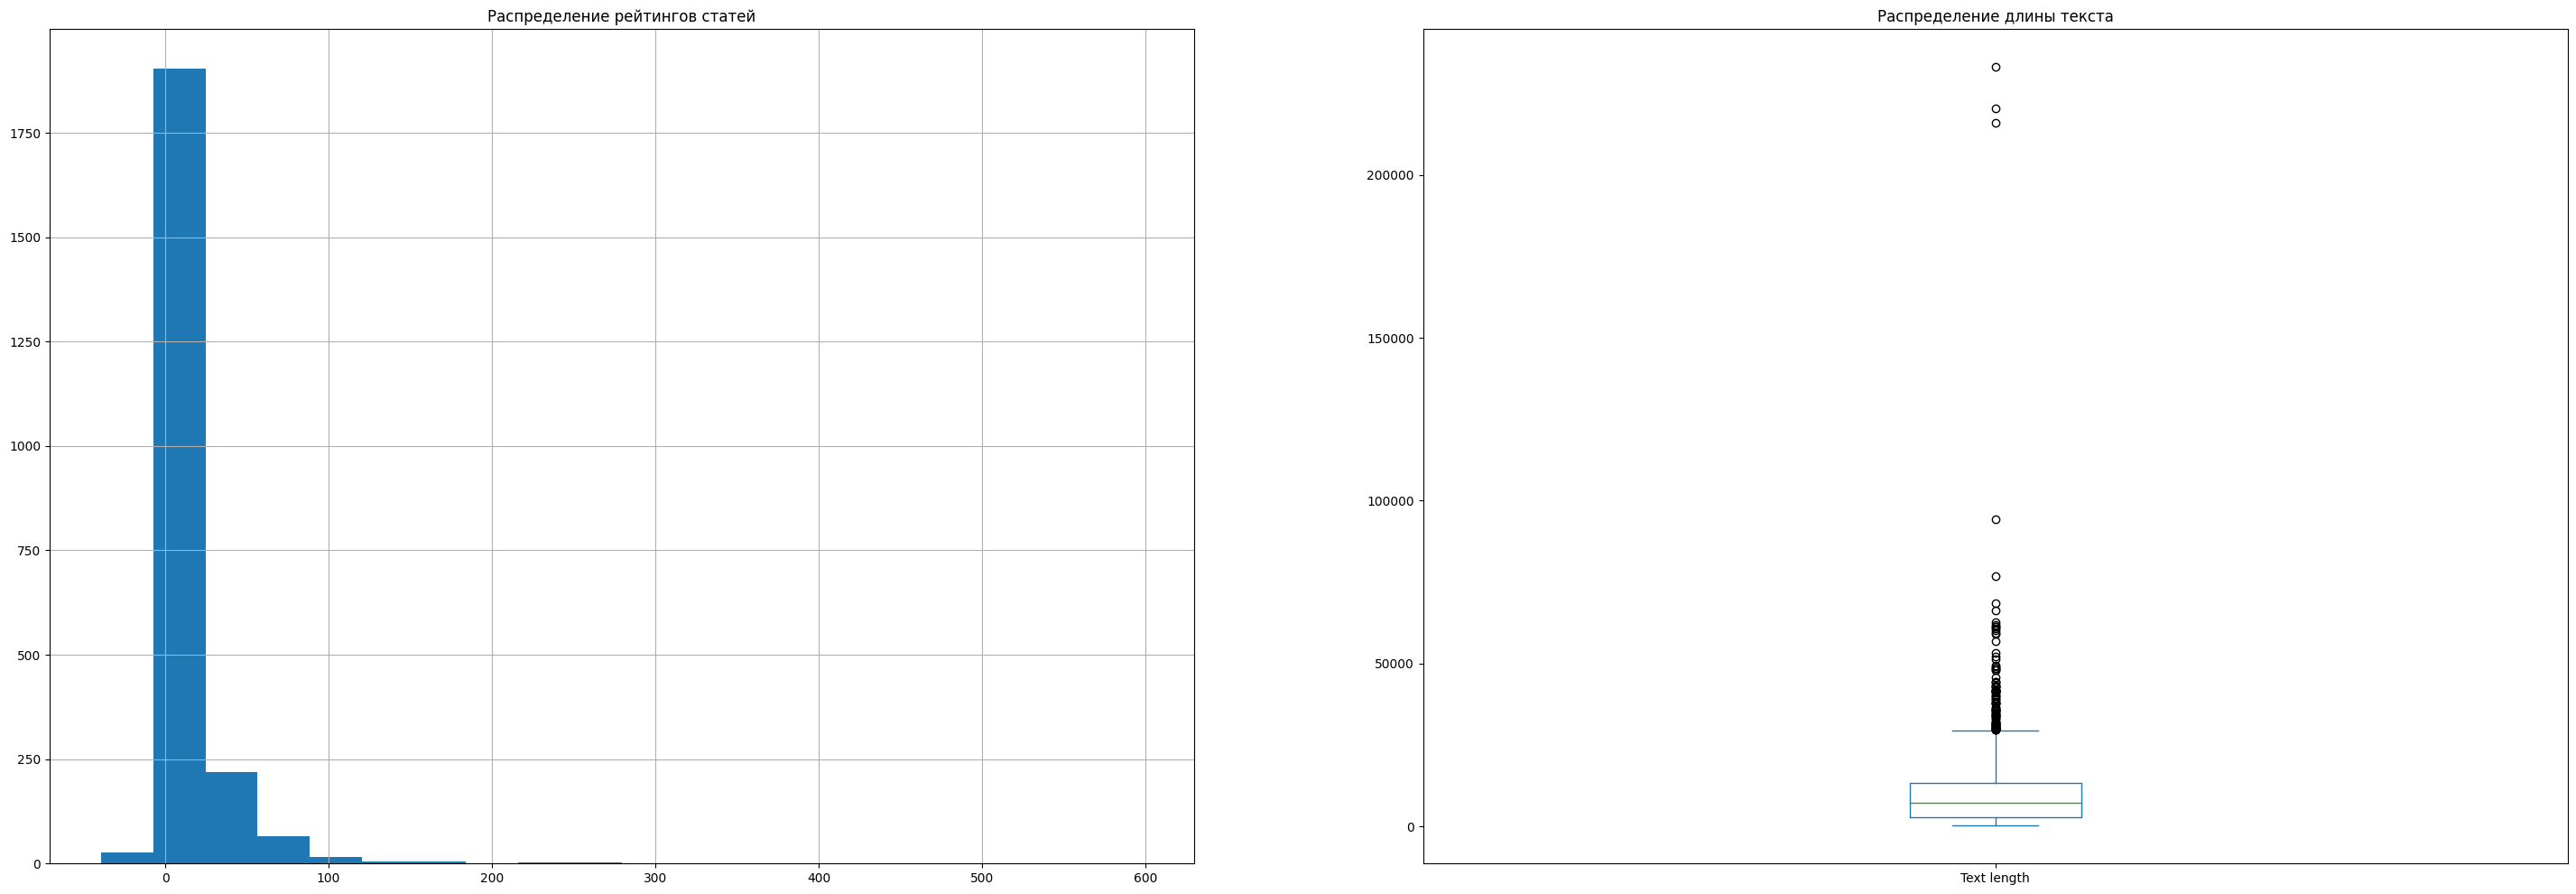

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Расчет базовых статистик
text_stats = {
    'avg_rating': df['Rating'].mean(),
    'avg_length': df['Text length'].mean(),
    'total_articles': len(df),
    'unique_hashtags': len(set([tag for sublist in df['Hashtags'] for tag in sublist]))
}

# Визуализация
plt.figure(figsize=(36, 12))
plt.subplot(1, 2, 1)
df['Rating'].hist(bins=20)
plt.title('Распределение рейтингов статей')

plt.subplot(1, 2, 2)
df['Text length'].plot(kind='box')
plt.title('Распределение длины текста')
plt.show()

In [ ]:
print(f"""
БАЗОВАЯ АНАЛИТИКА:
1. Средний рейтинг статей: {text_stats['avg_rating']:.1f}
2. Средняя длина текста: {text_stats['avg_length']:,} символов
3. Всего статей: {text_stats['total_articles']}
4. Уникальных хэштегов: {text_stats['unique_hashtags']}
5. Корреляция длина/рейтинг: {df['Text length'].corr(df['Rating']):.2f}
""")


БАЗОВАЯ АНАЛИТИКА:
1. Средний рейтинг статей: 14.5
2. Средняя длина текста: 10,190.262783459315 символов
3. Всего статей: 2249
4. Уникальных хэштегов: 145
5. Корреляция длина/рейтинг: 0.16



In [ ]:
# 3. Key skills analysis
all_skills = ', '.join(df['Hashtags'].dropna()).split(', ')
skills_counter = Counter(all_skills)
top_skills = pd.DataFrame(skills_counter.most_common(10), columns=['Skill', 'Count'])

print("\n=== TOP 10 Hashtags ===")
print(top_skills)




=== TOP 10 Hashtags ===
                         Skill  Count
0      искусственный интеллект     90
1            машинное обучение     58
2                    microsoft     53
3                       python     53
4  информационная безопасность     45
5                         игры     44
6             программирование     44
7                    нейросети     42
8                        apple     41
9                 тестирование     41


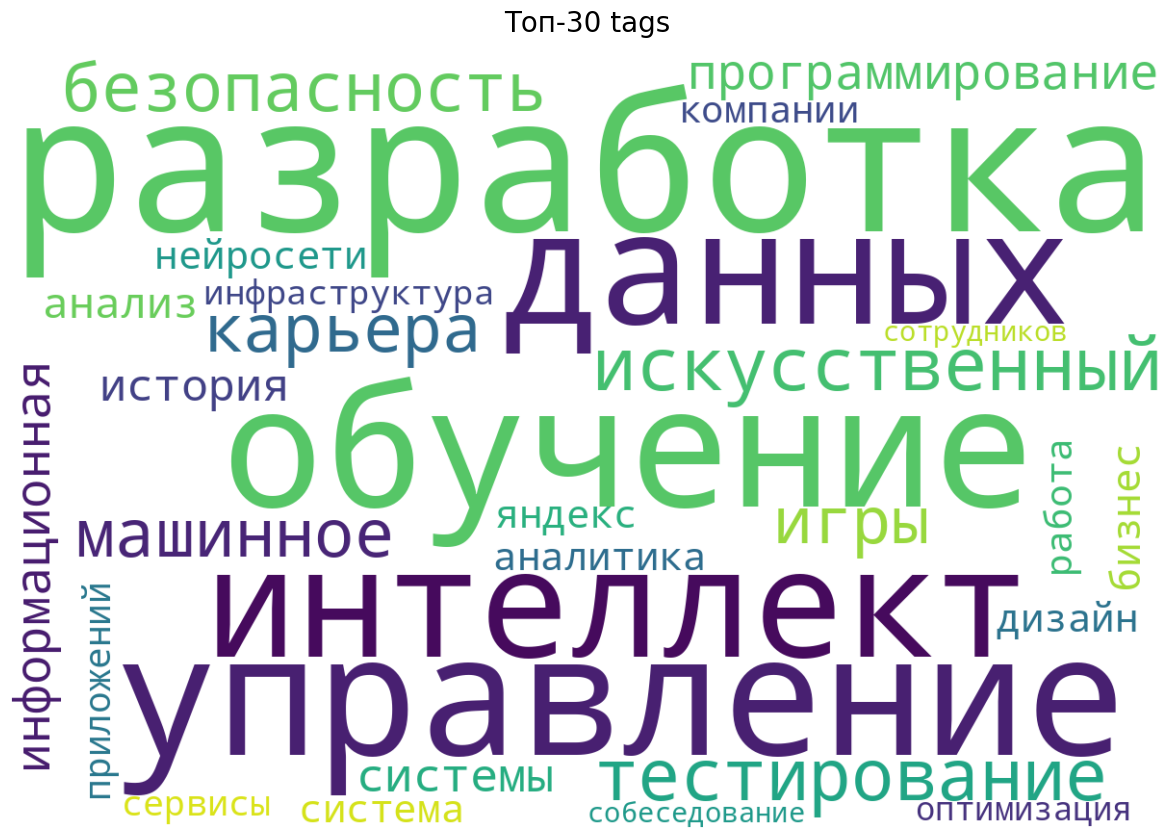

In [ ]:
texts = df['Hashtags'].str.cat(sep=' ').lower()
import re
# Очистка текста и подсчёт слов
words = re.findall(r'\b[а-яё]{4,}\b', texts)
word_freq = Counter(words).most_common(100)

# Параметры облака
wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    colormap='viridis',
    max_words=30,
    relative_scaling=0.5,
    min_font_size=10,
    max_font_size=200,
    random_state=42
).generate_from_frequencies(dict(word_freq))

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Топ-30 tags', fontsize=20, pad=20)
plt.show()